## Suggested workflow

    [] Get the data for materials with both elastic properties and ones without
    [] Train a model using materials data with elastic props
    [] Test my model with materials having calculated elastic properties
    [] Plot the results for a perspective on the accuracies
    [] Then use the model to predict the elastic props of materials without
    [] Plot the results to get a feel of the magnitude of the predicted elastic props
    [] Get a select few of the materials with predicted high props and study more


### Step 1: Get the data for materials with both elastic properties and ones without

In [43]:
import os, sys, random
from numpy import mat
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifParser, CifFile
import json
import csv
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

%matplotlib inline


In [7]:
API_TOKEN = os.environ.get("MPTOKEN")
DATA_PATH = ""
SCRIPT_PATH = ""
ROOT_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])

In [12]:
## Contact the materials database API and get all Tarnery materials in the database
## - Will filter for the Metals and Nitrates later

try:
    with open(os.path.join(ROOT_DIR, "candidates.json"), 'r') as fo:
        print(f"Found candidates json file, using data from it...")
        materials = json.load(fo)

except Exception as e:
    print(f"Could not get candidates json file, getting data and creating cson file")
    
    mpr = MPRester(API_TOKEN)

    crt = {
        # 'elements': {'$all': ['N']},
        'nelements': 3,
        # 'band_gap': {'$lt': 1},
    }
    prt = ['material_id', 'pretty_formula', 'full_formula', 'band_gap', 
            'unit_cell_formula', 'elements', 'elasticity', 'cif', 'icsd_ids']

    materials = mpr.query(criteria=crt, properties=prt)

    with open(os.path.join(ROOT_DIR, "candidates.json"), 'w') as fo:
        json.dump(materials, fo, indent=2)

Found candidates json file, using data from it...


In [14]:
print([x['pretty_formula'] for x in materials[:20]])

['AcEuAu2', 'NiAgSe2', 'PrSiAg', 'Cd(AgI2)2', 'RbAg3Se2', 'CrAgS2', 'CaAgBi', 'AgPPd5', 'TmAgTe2', 'TmAgS2', 'CeMgAg', 'YSiAg', 'TlAgPd2', 'CaInAg2', 'CaCdAg2', 'ZrAgHg2', 'NaAg2Pd', 'LiAgPd2', 'Ba2CdAg', 'AgPd2Au']


In [15]:
CANDIDATES_WITH = []  # A list of candidate materials with ealstic props
CANDIDATES_WITHOUT = [] # A list of candidate materials without ealstic props

for mat in materials:
    
    if mat['elasticity'] is None:
        CANDIDATES_WITHOUT.append(mat)
    else:
        CANDIDATES_WITH.append(mat)
    

print(f"Total Candidates: {len(materials)}")
print(f"Candidated found with elastic props: {len(CANDIDATES_WITH)}")
print(f"Candidated found without elastic props: {len(CANDIDATES_WITHOUT)}")

Total Candidates: 59023
Candidated found with elastic props: 7372
Candidated found without elastic props: 51651


### Step 2: Train a model using materials data with elastic props
##### Step 2.1 Create The Training data

In [27]:
ID_PROPS_DATA = []

## Create CIF files
print(f"Creating CIF files...")
for i in CANDIDATES_WITH:
    
    mat_name = f"{i['pretty_formula']}_{i['material_id']}"
    bulk_modulus = i['elasticity']['K_VRH']

    with open(os.path.join(ROOT_DIR, f"src/data/{mat_name}.cif"), 'w') as fo:
        fo.write(i['cif'])

    ## Create ID Properties csv file data
    ID_PROPS_DATA.append([mat_name, bulk_modulus])
    
## Create ID Properties csv file
print(f"Creating ID Properties csv file...")
with open(os.path.join(ROOT_DIR, f"src/data/id_prop.csv"), 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)

## Create atom Init json file
print(f"Creating atom Init json file...")
with open(os.path.join(ROOT_DIR, f"atom_init.json"), 'r') as fr:
    with open(os.path.join(ROOT_DIR, "src/data/atom_init.json"), 'w') as fw:
        json.dump(json.load(fr), fw, indent=2)

print(f"Done creating training data.")




Creating CIF files...
Creating ID Properties csv file...
Creating atom Init json file...
Done creating training data.


##### Step 2.2 Train the model

In [28]:
main_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/main.py")
data_file = os.path.join(ROOT_DIR, "src/data")

EPOCHS = 20
run_options = f"--train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs {EPOCHS}"


cmd = f"python \"{main_file}\" {run_options} \"{data_file}\""
print(cmd)

result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
print(result.stdout.decode("utf-8"))


python "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/main.py" --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs 20 "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/data"
Epoch: [0][0/18]	Time 5.956 (5.956)	Data 3.755 (3.755)	Loss 0.9747 (0.9747)	MAE 53.931 (53.931)
Epoch: [0][10/18]	Time 4.578 (4.668)	Data 3.659 (3.557)	Loss 0.3442 (0.8882)	MAE 32.377 (52.129)
Test: [0/6]	Time 3.304 (3.304)	Loss 0.7529 (0.7529)	MAE 44.553 (44.553)
 * MAE 47.029
Epoch: [1][0/18]	Time 1.351 (1.351)	Data 0.020 (0.020)	Loss 0.4381 (0.4381)	MAE 29.113 (29.113)
Epoch: [1][10/18]	Time 1.014 (1.264)	Data 0.015 (0.016)	Loss 0.3263 (0.2618)	MAE 22.166 (25.734)
Test: [0/6]	Time 0.266 (0.266)	Loss 0.4016 (0.4016)	MAE 36.436 (36.436)
 * MAE 35.588
Epoch: [2][0/18]	Time 1.217 (1.217)	Data 0.021 (0.021)	Loss 0.1722 (0.1722)	MAE 21.115 (21.115)
Epoch: [2][10/18]	Time 0.979 (1.052)	Data 0.015 (0.015)	Loss 0.1320 (0.1560)	MAE 1

           material  test     result    Unnamed: 3
0   HgIBr_mp-570172     0 -25.659584       #DIV/0!
1  RbAgO_mp-1008813     0  47.356838       #DIV/0!
2   TlGaSe2_mp-9580     1  45.154335  -44.15433502
3  TbGaI_mp-1025099     2  44.432991  -21.21649551
4   GeH3Cl_mp-28369     1  12.705582  -11.70558167
Working on the scatter plot...
Working on the bar plot...
Widht = 290
Done creating plots


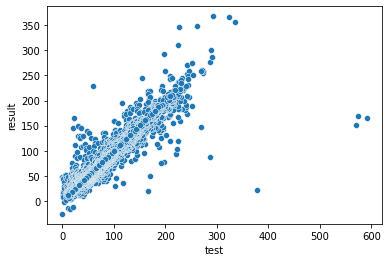

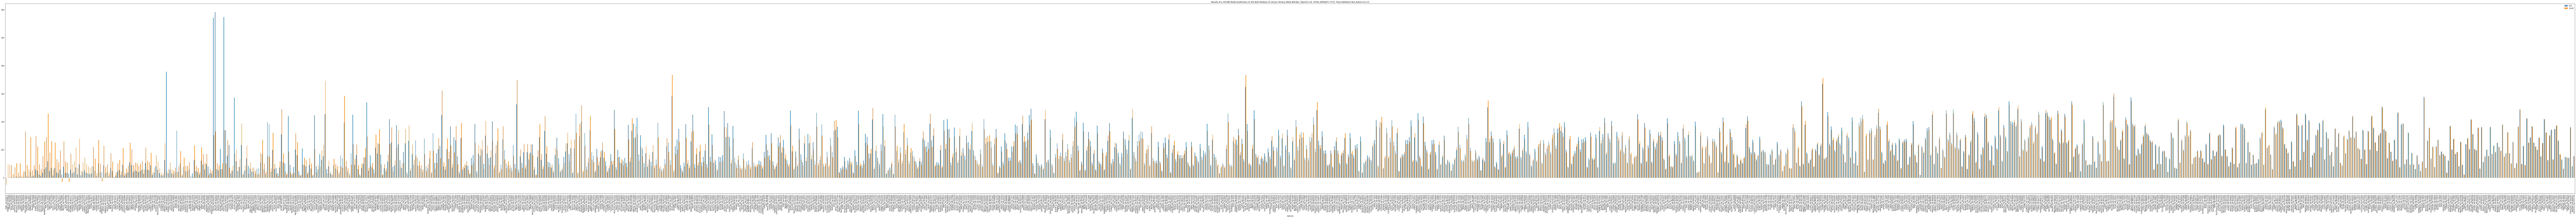

In [48]:
result_file = os.path.join(ROOT_DIR, "src/test_results.csv")

df = pd.read_csv(result_file)
df.dropna(subset=['material'], inplace=True)

print(df.head())

#sb.regplot(x="test", y="result", ci=None, data=df, color='r')

print(f"Working on the scatter plot...")
color_dict = dict({'test':'brown',
                  'result':'green'})
sb.scatterplot(x="test", y="result", data=df, palette=color_dict, legend='full')

print(f"Working on the bar plot...")
width = int((len(CANDIDATES_WITH) * 1) / 25.4)
print(f"Widht = {width}")
df.plot(x="material", y=["test", "result"], kind='bar', figsize=(width, 22),
        title=f"Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [Epochs={EPOCHS}, TOTAL-DATASET={len(CANDIDATES_WITH)}, Train-Validation-Test_Ratios=6:2:2]",
        sort_columns=True)

print("Done creating plots")

### Step 3: Test my model with materials having calculated elastic properties

In [29]:

main_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/main.py")
predict_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/predict.py")
data_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/data/transformers-reg")
bulk_model = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/pre-trained/bulk-moduli.pth.tar")
python_exe = os.path.join(ROOT_DIR, "venv/Scripts/python.exe")

# EPOCHS = 30
# run_options = f"--train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs {EPOCHS}"


# cmd = f"python \"{predict_file}\" \"{bulk_model}\" \"{data_file}\""
# print(cmd)

# result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
# print(result.stdout.decode("utf-8"))